<a href="https://colab.research.google.com/github/YASH-25/Mahine-Learning/blob/main/LAB_8%269.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LAB-8**

**1.Use makeblobs() to create a synthetic dataset of 100 samples with 2 classes.Apply SVM based classification and regression  for the synthetic dataset.**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import numbers
from sklearn.utils import check_array, check_random_state
from sklearn.utils import shuffle as shuffle_

def make_blobs(n_samples=100, n_features=2, centers=2, cluster_std=1.0,
               center_box=(-10.0, 10.0), shuffle=True, random_state=None):
    """Generate isotropic Gaussian blobs for clustering.

    Read more in the :ref:`User Guide <sample_generators>`.

    Parameters
    ----------
    n_samples : int, or tuple, optional (default=100)
        The total number of points equally divided among clusters.

    n_features : int, optional (default=2)
        The number of features for each sample.

    centers : int or array of shape [n_centers, n_features], optional
        (default=3)
        The number of centers to generate, or the fixed center locations.

    cluster_std: float or sequence of floats, optional (default=1.0)
        The standard deviation of the clusters.

    center_box: pair of floats (min, max), optional (default=(-10.0, 10.0))
        The bounding box for each cluster center when centers are
        generated at random.

    shuffle : boolean, optional (default=True)
        Shuffle the samples.

    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.

    Returns
    -------
    X : array of shape [n_samples, n_features]
        The generated samples.

    y : array of shape [n_samples]
        The integer labels for cluster membership of each sample.

    Examples
    --------
    >>> from sklearn.datasets.samples_generator import make_blobs
    >>> X, y = make_blobs(n_samples=10, centers=3, n_features=2,
    ...                   random_state=0)
    >>> print(X.shape)
    (10, 2)
    >>> y
    array([0, 0, 1, 0, 2, 2, 2, 1, 1, 0])

    See also
    --------
    make_classification: a more intricate variant
    """
    generator = check_random_state(random_state)

    if isinstance(centers, numbers.Integral):
        centers = generator.uniform(center_box[0], center_box[1],
                                    size=(centers, n_features))
    else:
        centers = check_array(centers)
        n_features = centers.shape[1]

    if isinstance(cluster_std, numbers.Real):
        cluster_std = np.ones(len(centers)) * cluster_std

    X = []
    y = []

    n_centers = centers.shape[0]
    if isinstance(n_samples, numbers.Integral):
        n_samples_per_center = [int(n_samples // n_centers)] * n_centers
        for i in range(n_samples % n_centers):
            n_samples_per_center[i] += 1
    else:
        n_samples_per_center = n_samples

    for i, (n, std) in enumerate(zip(n_samples_per_center, cluster_std)):
        X.append(centers[i] + generator.normal(scale=std,
                                               size=(n, n_features)))
        y += [i] * n

    X = np.concatenate(X)
    y = np.array(y)

    if shuffle:
        X, y = shuffle_(X, y, random_state=generator)

    return X, y

In [ ]:
def make_forge():
    # a carefully hand-designed dataset lol
    X, y = make_blobs(centers=2, random_state=4, n_samples=30)
    y[np.array([7, 27])] = 0
    mask = np.ones(len(X), dtype=np.bool)
    mask[np.array([0, 1, 5, 26])] = 0
    X, y = X[mask], y[mask]
    return X, y

In [ ]:
from matplotlib.colors import ListedColormap
cm2 = ListedColormap(['#0000aa', '#ff2020'])

def plot_2d_separator(classifier, X, fill=False, ax=None, eps=None, alpha=1,
                      cm=cm2, linewidth=None, threshold=None, linestyle="solid"):
    # binary?
    if eps is None:
        eps = X.std() / 2.

    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 100)
    yy = np.linspace(y_min, y_max, 100)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    try:
        decision_values = classifier.decision_function(X_grid)
        levels = [0] if threshold is None else [threshold]
        fill_levels = [decision_values.min()] + levels + [decision_values.max()]
    except AttributeError:
        # no decision_function
        decision_values = classifier.predict_proba(X_grid)[:, 1]
        levels = [.5] if threshold is None else [threshold]
        fill_levels = [0] + levels + [1]
    if fill:
        ax.contourf(X1, X2, decision_values.reshape(X1.shape),
                    levels=fill_levels, alpha=alpha, cmap=cm)
    else:
        ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=levels,
                   colors="black", alpha=alpha, linewidths=linewidth,
                   linestyles=linestyle, zorder=5)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

In [ ]:
import matplotlib as mpl
from matplotlib.colors import colorConverter

def discrete_scatter(x1, x2, y=None, markers=None, s=10, ax=None,
                     labels=None, padding=.2, alpha=1, c=None, markeredgewidth=None):
    """Adaption of matplotlib.pyplot.scatter to plot classes or clusters.

    Parameters
    ----------

    x1 : nd-array
        input data, first axis

    x2 : nd-array
        input data, second axis

    y : nd-array
        input data, discrete labels

    cmap : colormap
        Colormap to use.

    markers : list of string
        List of markers to use, or None (which defaults to 'o').

    s : int or float
        Size of the marker

    padding : float
        Fraction of the dataset range to use for padding the axes.

    alpha : float
        Alpha value for all points.
    """
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unique_y = np.unique(y)

    if markers is None:
        markers = ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(markers) == 1:
        markers = markers * len(unique_y)

    if labels is None:
        labels = unique_y

    # lines in the matplotlib sense, not actual lines
    lines = []

    current_cycler = mpl.rcParams['axes.prop_cycle']

    for i, (yy, cycle) in enumerate(zip(unique_y, current_cycler())):
        mask = y == yy
        # if c is none, use color cycle
        if c is None:
            color = cycle['color']
        elif len(c) > 1:
            color = c[i]
        else:
            color = c
        # use light edge for dark markers
        if np.mean(colorConverter.to_rgb(color)) < .4:
            markeredgecolor = "grey"
        else:
            markeredgecolor = "black"

        lines.append(ax.plot(x1[mask], x2[mask], markers[i], markersize=s,
                             label=labels[i], alpha=alpha, c=color,
                             markeredgewidth=markeredgewidth,
                             markeredgecolor=markeredgecolor)[0])

    if padding != 0:
        pad1 = x1.std() * padding
        pad2 = x2.std() * padding
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))

    return lines

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


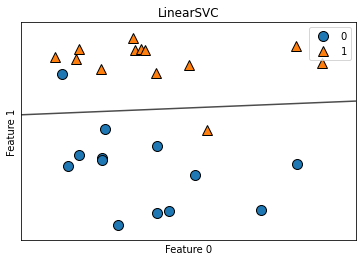

In [ ]:
from sklearn.svm import LinearSVC

X, y = make_forge()
model = LinearSVC()
clf = model.fit(X,y)
plot_2d_separator(clf, X, fill=False, eps=0.5, alpha=.7)
discrete_scatter(X[:, 0], X[:, 1], y)
plt.title("{}".format(clf.__class__.__name__))
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend()

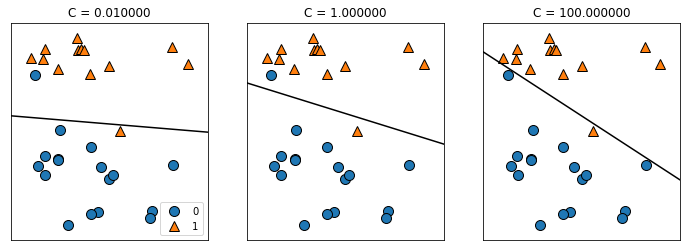

In [ ]:
from sklearn.svm import SVC

def plot_linear_svc_regularization():
    X, y = make_blobs(centers=2, random_state=4, n_samples=30)
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # a carefully hand-designed dataset lol
    y[7] = 0
    y[27] = 0
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

    for ax, C in zip(axes, [1e-2, 1, 1e2]):
        discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)

        svm = SVC(kernel='linear', C=C, tol=0.00001).fit(X, y)
        w = svm.coef_[0]
        a = -w[0] / w[1]
        xx = np.linspace(6, 13)
        yy = a * xx - (svm.intercept_[0]) / w[1]
        ax.plot(xx, yy, c='k')
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title("C = %f" % C)
    axes[0].legend(loc="best")
    
plot_linear_svc_regularization()

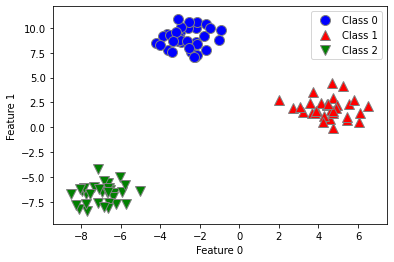

In [ ]:
X, y = make_blobs(centers=3, random_state=42)
discrete_scatter(X[:, 0], X[:, 1], y, c=['b', 'r', 'g'])
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend(["Class 0", "Class 1", "Class 2"])

In [ ]:
linear_svm = LinearSVC().fit(X, y)
print("Coefficient shape: ", linear_svm.coef_.shape)
print("Intercept shape: ", linear_svm.intercept_.shape)

Coefficient shape:  (3, 2)
Intercept shape:  (3,)


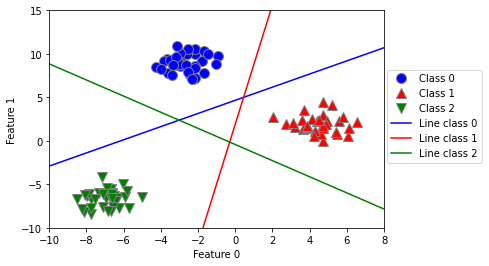

In [ ]:
discrete_scatter(X[:, 0], X[:, 1], y, c=['b', 'r', 'g'])
line = np.linspace(-15, 15)
for coef, intercept, color in zip(linear_svm.coef_, linear_svm.intercept_, ['b', 'r', 'g']):
    plt.plot(line, -(line * coef[0] + intercept) / coef[1], c=color)
plt.ylim(-10, 15)
plt.xlim(-10, 8)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend(['Class 0', 'Class 1', 'Class 2', 'Line class 0', 'Line class 1', 'Line class 2'], loc=(1.01, 0.3))

In [ ]:
cm3 = ListedColormap(['#0000aa', '#ff2020', '#50ff50'])

def plot_2d_classification(classifier, X, fill=False, ax=None, eps=None, alpha=1, cm=cm3):
    # multiclass
    if eps is None:
        eps = X.std() / 2.

    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    decision_values = classifier.predict(X_grid)
    ax.imshow(decision_values.reshape(X1.shape), extent=(x_min, x_max,
                                                         y_min, y_max),
              aspect='auto', origin='lower', alpha=alpha, cmap=cm)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

Text(0, 0.5, 'Feature 1')

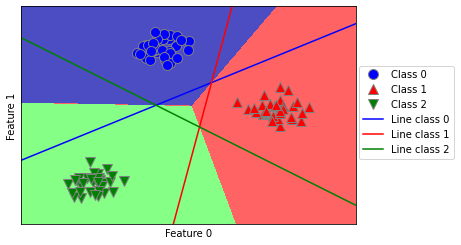

In [ ]:
plot_2d_classification(linear_svm, X, fill=True, alpha=.7)
discrete_scatter(X[:, 0], X[:, 1], y, c=['b', 'r', 'g'])
line = np.linspace(-15, 15)
for coef, intercept, color in zip(linear_svm.coef_, linear_svm.intercept_, ['b', 'r', 'g']):
    plt.plot(line, -(line * coef[0] + intercept) / coef[1], c=color)
plt.legend(['Class 0', 'Class 1', 'Class 2', 'Line class 0', 'Line class 1', 'Line class 2'], loc=(1.01, 0.3))
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

# **LAB-9**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
import seaborn as sns;sns.set()

In [ ]:
df = pd.read_csv("/content/Drug_Consumption.csv")

In [ ]:
df.dropna()

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,AScore,...,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,2,25-34,M,Doctorate degree,UK,White,-0.67825,1.93886,1.43533,0.76096,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
1,3,35-44,M,Professional certificate/ diploma,UK,White,-0.46725,0.80523,-0.84732,-1.62090,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
2,4,18-24,F,Masters degree,UK,White,-0.14882,-0.80615,-0.01928,0.59042,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
3,5,35-44,F,Doctorate degree,UK,White,0.73545,-1.63340,-0.45174,-0.30172,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0
4,6,65+,F,Left school at 18 years,Canada,White,-0.67825,-0.30033,-1.55521,2.03972,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL6,CL0,CL0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1879,1884,18-24,F,"Some college or university, no certificate or ...",USA,White,-1.19430,1.74091,1.88511,0.76096,...,CL0,CL0,CL0,CL3,CL3,CL0,CL0,CL0,CL0,CL5
1880,1885,18-24,M,"Some college or university, no certificate or ...",USA,White,-0.24649,1.74091,0.58331,0.76096,...,CL2,CL0,CL0,CL3,CL5,CL4,CL4,CL5,CL0,CL0
1881,1886,25-34,F,University degree,USA,White,1.13281,-1.37639,-1.27553,-1.77200,...,CL4,CL0,CL2,CL0,CL2,CL0,CL2,CL6,CL0,CL0
1882,1887,18-24,F,"Some college or university, no certificate or ...",USA,White,0.91093,-1.92173,0.29338,-1.62090,...,CL3,CL0,CL0,CL3,CL3,CL0,CL3,CL4,CL0,CL0


In [ ]:
print(df.isnull().sum())

ID           0
Age          0
Gender       0
Education    0
Country      0
Ethnicity    0
Nscore       0
Escore       0
Oscore       0
AScore       0
Cscore       0
Impulsive    0
SS           0
Alcohol      0
Amphet       0
Amyl         0
Benzos       0
Caff         0
Cannabis     0
Choc         0
Coke         0
Crack        0
Ecstasy      0
Heroin       0
Ketamine     0
Legalh       0
LSD          0
Meth         0
Mushrooms    0
Nicotine     0
Semer        0
VSA          0
dtype: int64


In [ ]:
df

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,AScore,...,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,2,25-34,M,Doctorate degree,UK,White,-0.67825,1.93886,1.43533,0.76096,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
1,3,35-44,M,Professional certificate/ diploma,UK,White,-0.46725,0.80523,-0.84732,-1.62090,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
2,4,18-24,F,Masters degree,UK,White,-0.14882,-0.80615,-0.01928,0.59042,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
3,5,35-44,F,Doctorate degree,UK,White,0.73545,-1.63340,-0.45174,-0.30172,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0
4,6,65+,F,Left school at 18 years,Canada,White,-0.67825,-0.30033,-1.55521,2.03972,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL6,CL0,CL0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1879,1884,18-24,F,"Some college or university, no certificate or ...",USA,White,-1.19430,1.74091,1.88511,0.76096,...,CL0,CL0,CL0,CL3,CL3,CL0,CL0,CL0,CL0,CL5
1880,1885,18-24,M,"Some college or university, no certificate or ...",USA,White,-0.24649,1.74091,0.58331,0.76096,...,CL2,CL0,CL0,CL3,CL5,CL4,CL4,CL5,CL0,CL0
1881,1886,25-34,F,University degree,USA,White,1.13281,-1.37639,-1.27553,-1.77200,...,CL4,CL0,CL2,CL0,CL2,CL0,CL2,CL6,CL0,CL0
1882,1887,18-24,F,"Some college or university, no certificate or ...",USA,White,0.91093,-1.92173,0.29338,-1.62090,...,CL3,CL0,CL0,CL3,CL3,CL0,CL3,CL4,CL0,CL0


In [ ]:
stringValues = ["Sex","Name","Ticket","Cabin","Embarked"]
for i in stringValues:
  # get all unique values in a list. Index of each 
  uniqueList = list(set(df[i]))
  # Create replace dictionary with key as string to be replaced and value as integer encoding for the string
  replaceDict = {}
  for j in range(len(uniqueList)):
    replaceDict[uniqueList[j]] = j
  df = df.replace({i : replaceDict})

KeyError: ignored